# ***KNN Balanced***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns

Study found. Loading from ../Study/optuna_study_KNN_cv_Balanced.pkl...
Model found. Loading from ../Models/knn_model_cv_Balanced.pkl...

Validation Metrics:
F1-Score (Validation): 0.7793
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      3211
           1       0.67      0.53      0.59       970
           2       0.53      0.52      0.53       586

    accuracy                           0.79      4767
   macro avg       0.68      0.66      0.67      4767
weighted avg       0.78      0.79      0.78      4767



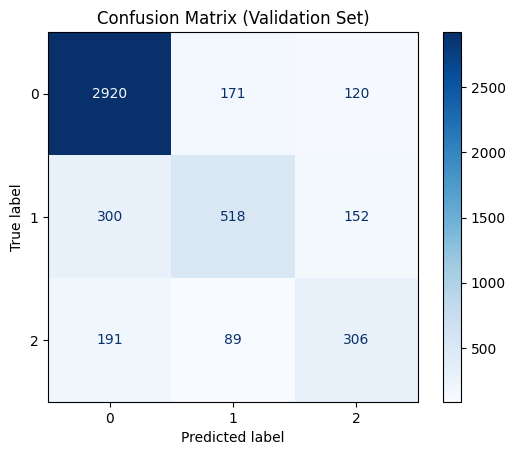

In [4]:
import os
import joblib
import pandas as pd
import numpy as np
import optuna
import time
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold

# Definir columnas numéricas para escalar dentro de cada fold
numeric_cols = ["CAPITAL", "CONTEO_PRODUCTOS", "Cupo", "DiasMejorGestion", "DiasUltimaGestion", "EDAD", 'GRUPO',
                'Mora_maxima_cliente__Asignacion', 'PgMin', 'SaldoCliente', 'SaldoVencido', 'TotalGestiones', 
                'TotalGestionesCD', 'TotalGestionesCI', 'TotalGestionesCompromiso', 'TotalGestionesMasivas',
                'TotalGestionesNC', 'dias_mora_Asignacion', 'saldo_total']

# Separar características y variable objetivo
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en conjunto de entrenamiento, validación y prueba (estratificado)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Definir nombres de archivos
model_filename = "../Models/knn_model_cv_Balanced.pkl"
study_filename = "../Study/optuna_study_KNN_cv_Balanced.pkl"
scaler_filename = "../Models/scaler_knn_final_Balanced.pkl"

# Verificar si el estudio existe
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_knn_balanced = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    pruner = optuna.pruners.MedianPruner()
    study_knn_balanced = optuna.create_study(direction="maximize", pruner=pruner)

    # Función objetivo para Optuna con validación cruzada y escalado dentro de cada fold
    def objective(trial):
        param = {
            "n_neighbors": trial.suggest_int("n_neighbors", 3, 50),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "p": trial.suggest_categorical("p", [1, 2])
        }

        f1_scores = []
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for train_idx, val_idx in kfold.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

            # Aplicar SMOTE para balancear los datos en cada fold
            smote = SMOTE(random_state=42)
            X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_train_fold, y_train_fold)

            # Escalar los datos
            scaler = StandardScaler()
            X_train_fold_resampled[numeric_cols] = scaler.fit_transform(X_train_fold_resampled[numeric_cols])
            X_val_fold[numeric_cols] = scaler.transform(X_val_fold[numeric_cols])

            # Entrenar modelo
            model = KNeighborsClassifier(**param)
            model.fit(X_train_fold_resampled, y_train_fold_resampled)

            # Evaluar en validación
            y_val_pred = model.predict(X_val_fold)
            f1_scores.append(f1_score(y_val_fold, y_val_pred, average="weighted"))

        return np.mean(f1_scores)

    start_time = time.time()
    study_knn_balanced.optimize(objective, n_trials=100)
    end_time = time.time()
    joblib.dump(study_knn_balanced, study_filename)
    print(f"Study saved as {study_filename}")

# Verificar si el modelo existe
if os.path.exists(model_filename) and os.path.exists(scaler_filename):
    print(f"Model found. Loading from {model_filename}...")
    knn_model_balanced = joblib.load(model_filename)
    scaler_final = joblib.load(scaler_filename)

    X_train[numeric_cols] = scaler_final.transform(X_train[numeric_cols])
    X_val[numeric_cols] = scaler_final.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler_final.transform(X_test[numeric_cols])
else:
    print("Model not found. Training a new one...")
    best_params = study_knn_balanced.best_params
    knn_model_balanced = KNeighborsClassifier(**best_params)

    # Aplicar SMOTE al conjunto de entrenamiento completo
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Escalar los datos
    scaler_final = StandardScaler()
    X_train_resampled[numeric_cols] = scaler_final.fit_transform(X_train_resampled[numeric_cols])
    X_val[numeric_cols] = scaler_final.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler_final.transform(X_test[numeric_cols])

    # Entrenar modelo final
    knn_model_balanced.fit(X_train_resampled, y_train_resampled)

    # Guardar modelo y escalador
    joblib.dump(knn_model_balanced, model_filename)
    joblib.dump(scaler_final, scaler_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en conjunto de validación
y_val_pred = knn_model_balanced.predict(X_val)
print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Graficar matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=knn_model_balanced.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [5]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "KNN Model_Balanced", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de KNN Model_Balanced guardado correctamente.


## ***Test Metrics***

In [6]:
# **Evaluación en el conjunto de prueba**
y_test_pred = knn_model_balanced.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest Metrics:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))




Test Metrics:
F1-Score (Test): 0.7805
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      3212
           1       0.66      0.55      0.60       969
           2       0.52      0.51      0.51       586

    accuracy                           0.79      4767
   macro avg       0.68      0.66      0.67      4767
weighted avg       0.78      0.79      0.78      4767



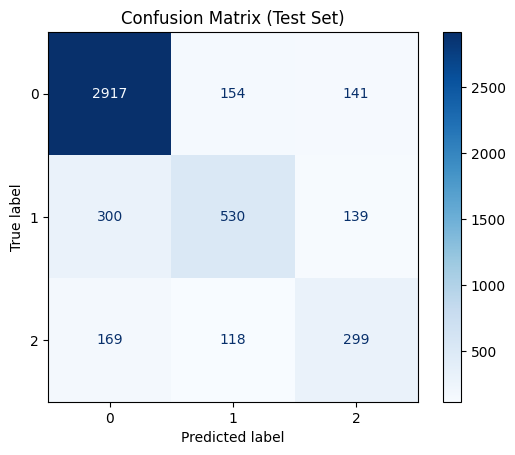

In [7]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=knn_model_balanced.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [8]:
optuna.visualization.plot_optimization_history(study_knn_balanced)

In [9]:
optuna.visualization.plot_parallel_coordinate(study_knn_balanced)

In [10]:
# Extract F1-scores from each trial in the study
f1_scores = [study_knn_balanced.trials[i].value for i in range(len(study_knn_balanced.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_knn_balanced.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [11]:
optuna.visualization.plot_slice(study_knn_balanced, params=['n_neighbors', 'weights', 'p'])


In [12]:
optuna.visualization.plot_param_importances(study_knn_balanced)

In [13]:
knn_model_balanced

KNeighborsClassifier(n_neighbors=47, p=1, weights='distance')

In [14]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "KNN Model_Balanced", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de KNN Model_Balanced guardado correctamente.
